See code at https://github.com/google-research/vision_transformer/

This Colab is about the paper

- LiT: Zero-Shot Transfer with Locked-image text Tuning: https://arxiv.org/abs/2111.07991

For ViT, MLP Mixer etc see the other Colab

https://colab.researc.google.com/github/google-research/vision_transformer/blob/main/vit_jax.ipynb

### Load model

In [ ]:
# Installs the vit_jax package from Github.
!pip install -q git+https://github.com/google-research/vision_transformer

In [ ]:
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tqdm

from vit_jax import models

In [ ]:
# Currently available LiT models
[name for name in models.model_configs.MODEL_CONFIGS if name.startswith('LiT')]

['LiT-B16B', 'LiT-L16L']

In [ ]:
model_name = 'LiT-B16B'

lit_model = models.get_model(model_name)
# Loading the variables from cloud can take a while the first time...
lit_variables = lit_model.load_variables()
# Creating tokens from freeform text (see next section).
tokenizer = lit_model.get_tokenizer()
# Resizing images & converting value range to -1..1 (see next section).
image_preprocessing = lit_model.get_image_preprocessing()
# Preprocessing op for use in tfds pipeline (see last section).
pp = lit_model.get_pp()

### Use model

In [ ]:
# Let's load some sample images from tfds.
# Alternatively you can also load these images from the internet / your Drive.
ds = tfds.load('imagenette', split='train')
images_list = [
    example['image'].numpy()
    for _, example in zip(range(5), ds)
]
# Note that this is a list of images with different shapes, not a four
# dimensional tensor.
[image.shape for image in images_list]

[(101, 125, 3), (375, 500, 3), (335, 500, 3), (429, 500, 3), (359, 500, 3)]

In [ ]:
# Note that our preprocessing converts to floats ranging from -1..1 !
images = image_preprocessing(images_list)
images.shape, images.min(), images.max()

((5, 224, 224, 3), -1.0, 1.0)

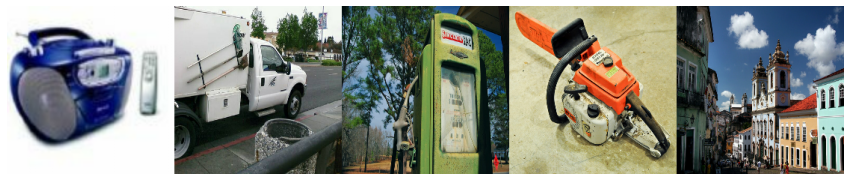

In [ ]:
plt.figure(figsize=(15, 4))
plt.imshow(np.hstack(images) * .5 + .5)
plt.axis('off');

In [ ]:
texts = [
    'itap of a cd player',
    'a photo of a truck',
    'gas station',
    'chainsaw',
    'a bad photo of colorful houses',
]
tokens = tokenizer(texts)
tokens.shape

(5, 16)

In [ ]:
# Embed both texts and images with a single model call.
# See next section for embedding images/texts separately.
zimg, ztxt, out = lit_model.apply(lit_variables, images=images, tokens=tokens)

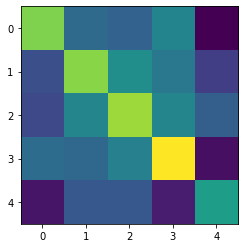

In [ ]:
plt.imshow(ztxt @ zimg.T)

In [ ]:
probs = np.array(jax.nn.softmax(out['t'] * ztxt @ zimg.T, axis=1))
pd.DataFrame(probs, index=texts).style.background_gradient('Greens', vmin=0, vmax=1).format('{:.2%}')

,0,1,2,3,4
itap of a cd player,99.72%,0.04%,0.02%,0.23%,0.00%
a photo of a truck,0.01%,99.55%,0.37%,0.07%,0.00%
gas station,0.00%,0.12%,99.76%,0.11%,0.01%
chainsaw,0.00%,0.00%,0.01%,99.99%,0.00%
a bad photo of colorful houses,0.02%,0.81%,0.80%,0.03%,98.34%


### `tfds` zero-shot evaluation

In [ ]:
# Load dataset and create array of class names.
builder = tfds.builder('cifar100')
builder.download_and_prepare()
ds_test = builder.as_dataset('test')
info = builder.info
classnames = [
    info.features['label'].int2str(id_)
    for id_ in range(info.features['label'].num_classes)
]
classnames[:10]

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle']

In [ ]:
# "best prompts" from CLIP paper (https://arxiv.org/abs/2103.00020)
PROMPTS = [
    'itap of a {}.',
    'a bad photo of the {}.',
    'a origami {}.',
    'a photo of the large {}.',
    'a {} in a video game.',
    'art of the {}.',
    'a photo of the small {}.',
    '{}',
]

texts = [
    prompt.format(classname)
    for classname in classnames
    for prompt in PROMPTS
]
len(texts)

800

In [ ]:
# Tokenize the texts using numpy like before.
tokens = tokenizer(texts)
tokens.shape

(800, 16)

In [ ]:
_, ztxt, _ = lit_model.apply(lit_variables, tokens=tokens)
ztxt.shape

(800, 768)

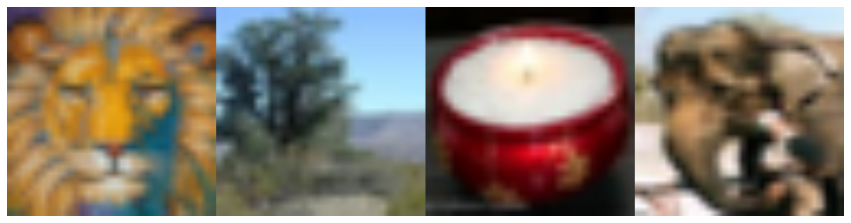

In [ ]:
# `pp` from above (section "Load model") is a TensorFlow graph that can
# efficiently be added to the input pre-processing.
imgs = next(iter(ds_test.map(pp).batch(4)))['image']
# Note that `pp` would also tokenize "texts" to "tokens", if such a feature was
# present in the dataset (which is not the case for cifar).

plt.figure(figsize=(15, 4))
plt.imshow(np.hstack(imgs) * .5 + .5)
plt.axis('off');

In [ ]:
# JIT-compile image embedding function because there are lots of images.
@jax.jit
def embed_images(variables, images):
  zimg, _, _ = lit_model.apply(variables, images=images)
  return zimg

In [ ]:
# Compute all images embeddings & collect correct labels.
zimgs = []
labels = []

for batch in tqdm.tqdm(ds_test.map(lit_model.get_pp()).batch(500)):
  labels += list(batch['label'].numpy())
  zimg = embed_images(lit_variables, batch['image'].numpy())
  zimgs.append(np.array(zimg))
zimgs = np.concatenate(zimgs)
zimgs.shape

100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


(10000, 768)

In [ ]:
# Compute similarities ...
sims = zimgs @ ztxt.reshape([len(classnames), len(PROMPTS), -1]).mean(axis=1).T
sims.shape

(10000, 100)

In [ ]:
# ... and use most similar embedding to predict label.
(sims.argmax(axis=1) == np.array(labels)).mean()
# Expected accuracy for model "LiT-B16B" : 79.19

DeviceArray(0.7919, dtype=float32)